In [1]:
spark = SparkSession.builder \
    .master("spark://localhost:7077") \
    .appName("Credit Fraud") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

NameError: name 'SparkSession' is not defined

In [3]:
import time, math, csv, datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date 
#from skimpy import skim
import lightgbm as lgb
#import seaborn as sns
import numpy as np
import sklearn
from pyspark.sql import SparkSession

In [4]:
def agefromdob(df):    
    ages = []
    for x in df['dob']:
        xage = pd. to_datetime('today'). year-pd. to_datetime(x). year
        ages.append(xage)
    df['age'] = ages

In [5]:
df_train = pd.read_csv('fraudtrain.csv', header=0)
df_test = pd.read_csv('fraudtest.csv', header=0)

In [6]:
df_train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [7]:
categoricalfeatures = [ 'city', 'merchant', 'job', 'category', 'state', 'first', 'last', 'zip'] 
for x in categoricalfeatures:
    df_test[x] = pd.Categorical(df_test[x])
    df_train[x] = pd.Categorical(df_train[x])


In [8]:
agefromdob(df_train)
agefromdob(df_test)

In [9]:
df_train['is_fraud'].value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [10]:
features = ['lat', 'long','amt','city_pop', 'merch_lat', 'merch_long', 'city', 'merchant', 'job', 'category', 'age', 'zip'] #, 'state', 'first', 'last'
train_data = lgb.Dataset(df_train[features], df_train['is_fraud'],feature_name = 'auto')
test_data = lgb.Dataset(df_test[features] , df_test['is_fraud'], feature_name = 'auto')
#.write().csv("output")
#, 'unix_time'

In [53]:
params = {'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.03, 'num_leaves': 300, 'boosting': 'dart', 'force_col_wise': True, 'num_threads': 8, 'num_iterations': 200, 'feature_pre_filter': 'false', 'max_bin': 2000}
evals = {} # 'min_data_in_bin': 1 , 'min_data_in_leaf':30 
model = lgb.train(params, train_data, valid_sets=[train_data, test_data], valid_names=['train', 'test'], callbacks=[lgb.record_evaluation(evals)])

/Users/Lynden/opt/anaconda3/envs/jupyter/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7506, number of negative: 1289169
[LightGBM] [Info] Total Bins 11690
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146050
[LightGBM] [Info] Start training from score -5.146050


/Users/Lynden/opt/anaconda3/envs/jupyter/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/Lynden/opt/anaconda3/envs/jupyter/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

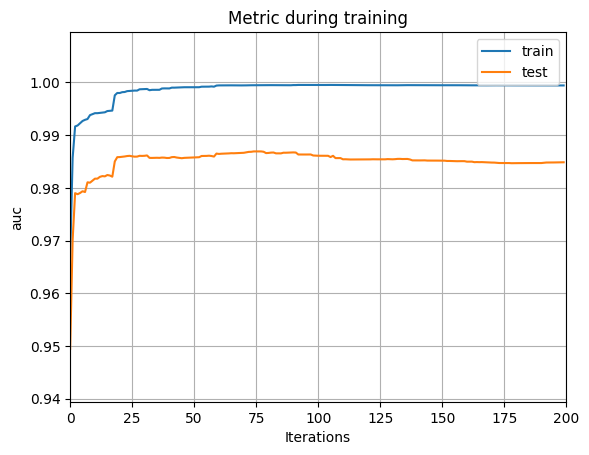

In [54]:
lgb.plot_metric(evals)

In [55]:

pred = model.predict(
  df_test[features]
)
pred_label = np.round(pred)

In [56]:
np.sum(pred_label == df_test['is_fraud']) / pred_label.shape[0]

0.9975545194603748

0    553574
1      2145
Name: is_fraud, dtype: int64
f1: 0.640761300555115


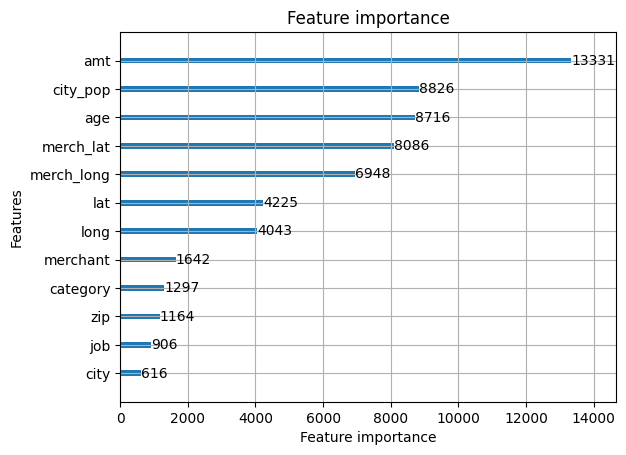

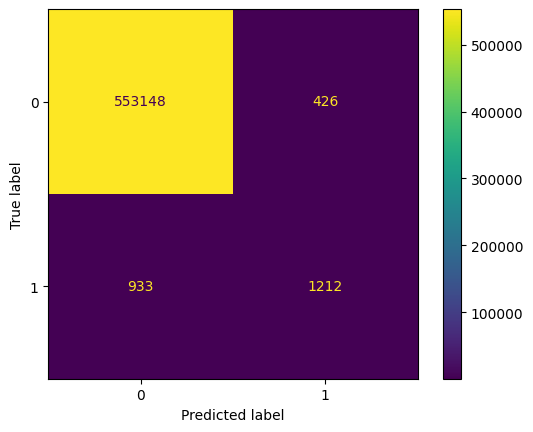

In [57]:
print(df_test['is_fraud'].value_counts())
lgb.plot_importance(model)
confusion = sklearn.metrics.confusion_matrix(df_test['is_fraud'], pred_label)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion)
f1score = sklearn.metrics.f1_score(df_test['is_fraud'], pred_label)
print("f1: " + str(f1score))
disp.plot()